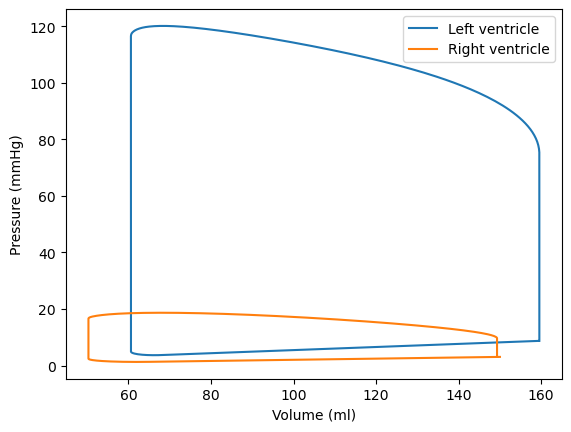

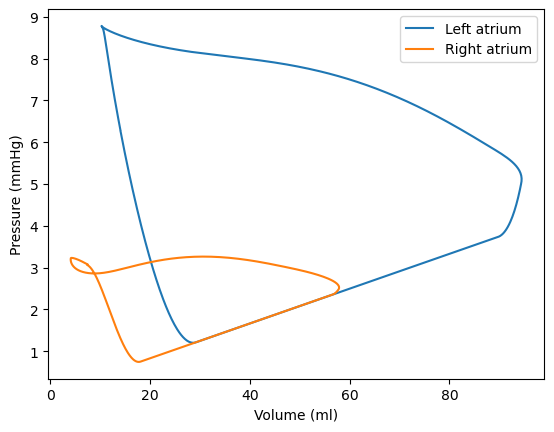

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define parameters
E_max_lv = 1.9326 # Maximal elastance of left ventricle
E_min_lv = 0.0548 # Minimal elastance of left ventricle
E_max_rv = 0.3382  # Maximal elastance of right ventricle
E_min_rv = 0.0205  # Minimal elastance of right ventricle
E_max_la = 0.8567  # Maximal elastance of left atrium
E_min_la = 0.0416  # Minimal elastance of left atrium
E_max_ra = 0.7908  # Maximal elastance of right atrium
E_min_ra = 0.0416  # Minimal elastance of right atrium

T_es_v = 0.3 # End systolic time of ventricle
T_ep_v= 0.5 # End pulse time of ventricle
T_ep_a = 0.1 # End pulse time of atrium
T_bs_a = 0.45 # Beginning of systolic time of atrium
T_es_a = 0.9 # End systolic time of atrium
T_cycle = 1.0 # Cardiac cycle time

Z_ao = 0.0144 # Aortic valve resistance
R_mv = 0.0030 # Mitral valve resistance
R_pu = 0.0025  # Pulmonary valve resistance
R_ts = 0.0030  # Tricuspid valve resistance

R_s = 0.8640 # Systemic resistance
R_sv = 0.0720 # Systemic venous resistance
R_p = 0.0360  # Pulmonary resistance
R_pv = 0.0360  # Pulmonary venous resistance
C_sa = 1.7986 # Systemic arterial compliance
C_sv = 30.1297 # Systemic venous compliance
C_pa = 6.9102 # Pulmonary arterial compliance
C_pv = 11.5328 # Pulmonary venous compliance


# Define the elastance function for ventricle
def elastance_v(T, E_max, E_min):
    t = T % T_cycle
    if t < T_es_v:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * t / T_es_v)) + E_min
    elif t < T_ep_v:
        return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_v) / (T_ep_v - T_es_v))) + E_min
    else:
        return E_min


# Define the elastance function for atrium
def elastance_a(T, E_max, E_min):
    t = T % T_cycle
    if t < T_ep_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_ep_a) / (T_cycle - T_es_a + T_ep_a))) + E_min
    elif t < T_bs_a:
        return E_min
    elif t < T_es_a:
        return (E_max - E_min) * 0.5 * (1 - np.cos(np.pi * (t - T_bs_a) / (T_es_a - T_bs_a))) + E_min
    else:
        return (E_max - E_min) * 0.5 * (1 + np.cos(np.pi * (t - T_es_a) / (T_cycle - T_es_a + T_ep_a))) + E_min




# Define the valve flow functions
def valve(P_in, P_out, R):
    if P_in > P_out:
        q = (P_in - P_out) / R
    else:
        q = 0.0
    return q

# Define the system of ODEs
def model(t, y):
    V_lv = y[0] # stressed Left ventricular volume
    V_rv = y[1] # stressed Right ventricular volume
    V_la = y[2] # stressed Left atrial volume
    V_ra = y[3] # stressed Right atrial volume
    V_sa = y[4] # stressed Systemic arterial volume
    V_sv = y[5] # stressed Systemic venous volume
    V_pa = y[6] # stressed Pulmonary arterial volume
    V_pv = y[7] # stressed Pulmonary venous volume


    # Pressures
    P_lv = elastance_v(t, E_max_lv, E_min_lv) * V_lv # Left ventricular pressure
    P_rv = elastance_v(t, E_max_rv, E_min_rv) * V_rv # Right ventricular pressure
    P_la = elastance_a(t, E_max_la, E_min_la) * V_la # Left atrial pressure
    P_ra = elastance_a(t, E_max_ra, E_min_ra) * V_ra # Right atrial pressure
    P_sa = V_sa / C_sa # Systemic arterial pressure
    P_sv = V_sv / C_sv # Systemic venous pressure
    P_pa = V_pa / C_pa # Pulmonary arterial pressure
    P_pv = V_pv / C_pv # Pulmonary venous pressure

    # Flow rates
    Q_sa = valve(P_lv, P_sa, Z_ao) # Systemic arterial (AO) flow
    Q_sv = (P_sa - P_sv) / R_s # Systemic venous flow
    Q_ra = (P_sv -P_ra) / R_sv # Right atrial flow
    Q_rv = valve(P_ra, P_rv, R_ts) # Right ventricular (TS) flow
    Q_pa = valve(P_rv, P_pa, R_pu) # Pulmonary arterial (PU) flow
    Q_pv = (P_pa - P_pv) / R_p # Pulmonary venous flow
    Q_la = (P_pv - P_la) / R_pv # Left atrial flow
    Q_lv = valve(P_la, P_lv, R_mv) # Left ventricular (MV) flow

    # Equations for variables
    dV_lv_dt = Q_lv - Q_sa
    dV_rv_dt = Q_rv - Q_pa
    dV_la_dt = Q_la - Q_lv
    dV_ra_dt = Q_ra - Q_rv
    dV_sa_dt = Q_sa - Q_sv
    dV_sv_dt = Q_sv - Q_ra
    dV_pa_dt = Q_pa - Q_pv
    dV_pv_dt = Q_pv - Q_la


    return [dV_lv_dt, dV_rv_dt, dV_la_dt, dV_ra_dt, dV_sa_dt, dV_sv_dt, dV_pa_dt, dV_pv_dt]


# Initial conditions
y0 = [146, 146, 48.1, 48.1, 167.2, 241.1, 83.0, 57.6]

# Time span
t_span = (0* T_cycle, 5 * T_cycle)
t_eval = np.linspace(*t_span, 5000)

# Solve the ODEs
sol = solve_ivp(model, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-8)

# calculate the pressures
P_lv = [elastance_v(t, E_max_lv, E_min_lv) * V for t, V in zip(sol.t, sol.y[0])]
P_lv =np.array(P_lv)
P_rv = [elastance_v(t, E_max_rv, E_min_rv) * V for t, V in zip(sol.t, sol.y[1])]
P_rv = np.array(P_rv)
P_la = [elastance_a(t, E_max_la, E_min_la) * V for t, V in zip(sol.t, sol.y[2])]
P_la = np.array(P_la)
P_ra = [elastance_a(t, E_max_ra, E_min_ra) * V for t, V in zip(sol.t, sol.y[3])]
P_ra = np.array(P_ra)

# select one cardiac cycle
time_selection = (sol.t >= 4 * T_cycle) & (sol.t <= 5 * T_cycle)
index = np.where(time_selection)
selected_times = sol.t[index]


# Plot volume-pressure loops for the ventricles in the last cardiac cycle
plt.figure()
plt.plot(sol.y[0][index], P_lv[index], label='Left ventricle')
plt.plot(sol.y[1][index], P_rv[index], label='Right ventricle')
plt.xlabel('Volume (ml)')
plt.ylabel('Pressure (mmHg)')
plt.legend()

# Plot volume-pressure loops for the atria in the last cardiac cycle
plt.figure()
plt.plot(sol.y[2][index], P_la[index], label='Left atrium')
plt.plot(sol.y[3][index], P_ra[index], label='Right atrium')
plt.xlabel('Volume (ml)')
plt.ylabel('Pressure (mmHg)')
plt.legend()


